# Analysis of Data Science Content on Stack Exchange - Popular Data Science Questions

Our goal in this project is to use [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine what content should a data science education company create, based on interest by subject.

### Stack Exchange
#### What kind of questions are welcome on this site?

On DSSE's help center's [section on questions](https://datascience.stackexchange.com/help/asking) , we can read that we should:

   * Avoid subjective questions.
   * Ask practical questions about Data Science — there are adequate sites for theoretical questions.
   * Ask specific questions.
   * Make questions relevant to others.

All of these characteristics, if employed, should be helpful attributes to our goal.

In the help center we also learned that in addition to the sites mentioned in the Learn section, there are other two sites that are relevant:

   * [Open Data](https://opendata.stackexchange.com/help/on-topic) (Dataset requests)
   * [Computational Science](https://scicomp.stackexchange.com/help/on-topic) (Software packages and algorithms in applied mathematics)

#### What, other than questions, does DSSE's [home](https://datascience.stackexchange.com/) subdivide into?

On the [home page](https://datascience.stackexchange.com/) we can see that we have four sections:

   * [Questions](https://datascience.stackexchange.com/questions) — a list of all questions asked;

   * [Tags](https://datascience.stackexchange.com/tags) — a list of tags (keywords or labels that categorize questions);



  * [Users](https://datascience.stackexchange.com/users) — a list of users;
  * [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions;

The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

#### What information is available in each post?

Looking, just as an example, at [this](https://datascience.stackexchange.com/questions/19141/linear-model-to-generate-probability-of-each-possible-output?rq=1) question, some of the information we see is:

   * For both questions and answers:
        * The posts's score;
        * The posts's title;
        * The posts's author;
        * The posts's body;
   * For questions only:
        * How many users have it on their "
        * The last time the question as active;
        * How many times the question was viewed;
        * Related questions;
        * The question's tags;

### Stack Exchange Data Explorer

Perusing the table names, a few stand out as relevant for our goal:

   * Posts
   * PostTags
   * Tags
   * TagSynonyms

Running a few exploratory queries, leads us to focus our efforts on Posts table. For example: the Tags table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

The posts table has a lot of columns. We'll be focusing our attention on those that seem relevant towards our goal:

   * Id: An identification number for the post.
   * PostTypeId: An identification number for the type of post.
   * CreationDate: The date and time of creation of the post.
   * Score: The post's score.
   * ViewCount: How many times the post was viewed.
   * Tags: What tags were used.
   * AnswerCount: How many answers the question got (only applicable to question posts).
   * FavoriteCount: How many times the question was favored (only applicable to question posts).

Note that with the exception of the tags column, the last few columns contain information about how popular the post is — the kind of information we're after.

There are eight different types of post: where PostTypeId 1 = questions and PostTypeId 2 = answers, but we'll just focus on questions. Also, since we're only interested in recent posts, we'll limit our analysis to the posts of 2019 (At the time of writing it is early 2020).

## Getting the Data

To get the relevant data we run the following query against the SEDE DSSE database, then download the dataset in csv format which will be used in this project.

`SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;`

## Exploring the Data

We can read in the dataset while immediately making sure CreationDate will be stored as a datetime object:


In [1]:
# We import everything that we'll use

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
questions = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate'])

In [3]:
print(questions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB
None




We see that only FavoriteCount has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

Since the object dtype is a catch-all type, let's see what types the objects in questions["Tags"] are.


In [4]:
questions["Tags"].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)



We see that every value in this column is a string. On Stack Exchange, each question can only have a maximum of five tags [(source)](https://meta.stackexchange.com/a/18879), so one way to deal with this column is to create five columns in questions called Tag1, Tag2, Tag3, Tag4, and Tag5 and populate the columns with the tags in each row.

However, since doesn't help is relating tags from one question to another, we'll just keep them as a list.


## Cleaning the Data

In [5]:
# cleaning the favoritecount column and converting dtype to int

questions.fillna(value={"FavoriteCount": 0}, inplace=True)
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

 Below, we'll modify Tags column to make it easier to work with

In [6]:
print('Tags column before cleaning: \n', questions["Tags"].head())

Tags column before cleaning: 
 0                      <machine-learning><data-mining>
1    <machine-learning><regression><linear-regressi...
2         <python><time-series><forecast><forecasting>
3                <machine-learning><scikit-learn><pca>
4             <dataset><bigdata><data><speech-to-text>
Name: Tags, dtype: object


In [7]:
questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")

In [8]:
print('Tags column after cleaning: \n',questions["Tags"].head())

Tags column after cleaning: 
 0                      [machine-learning, data-mining]
1    [machine-learning, regression, linear-regressi...
2         [python, time-series, forecast, forecasting]
3                [machine-learning, scikit-learn, pca]
4             [dataset, bigdata, data, speech-to-text]
Name: Tags, dtype: object


In [9]:
# check out the changes we made in the questions dataframe

questions.sample(10)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
7787,54491,2019-06-25 20:14:51,3,1516,[keras],1,0
1848,46646,2019-03-04 15:09:30,3,245,"[r, cross-validation, unbalanced-classes, over...",1,1
7048,43485,2019-01-04 14:02:00,0,227,"[machine-learning, decision-trees, feature-ext...",1,0
5649,63181,2019-11-15 02:33:00,0,17,"[keras, dataset, data-cleaning, image-recognit...",0,0
8153,65241,2019-12-21 17:09:07,0,37,"[nlp, natural-language-process, bert, machine-...",2,1
2934,58905,2019-09-09 12:56:09,2,35,[k-nn],2,0
1999,57805,2019-08-19 13:59:38,1,18,"[deep-learning, gan]",0,0
8838,55419,2019-07-10 10:31:23,1,168,[k-nn],1,0
2358,58352,2019-08-28 23:48:25,0,23,"[machine-learning, neural-network, recurrent-n...",0,0
5629,62861,2019-11-08 05:38:20,1,28,"[machine-learning, xgboost, accuracy]",2,0


## Most Used and Most Viewed

Here, we'll focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used (tag_count), and how many times a question with that tag was viewed (tag_view_count). Then, we'll create two dataframes from the results of top 20 tag_count and top 20 tag_view_count:
  
   * most_used is a dataframe that counts how many times each of the top 20 tags was used.
   * most_viewed is a dataframe that counts how many times each of the top 20 tags was viewed.
  
We'll begin by counting how many times each tag was used

In [10]:
tag_count = dict()

for tags in questions['Tags']:
    for i in tags:
        if i in tag_count:
            tag_count[i]+=1
        else:
            tag_count[i] = 1
        

For improved aesthetics, let's transform tag_count in a dataframe

In [11]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)

,Count
named-entity-recognition,36
scikit-learn,540
dataframe,81
ensemble-learning,11
marketing,6
groupby,2
semi-supervised-learning,18
mathematics,17
simulation,11
pooling,4


Let's now sort this dataframe by Count and visualize the top 20 results

In [12]:
most_used = tag_count.sort_values(by="Count").tail(20)
most_used

,Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


The threshold of 20 is somewhat arbitrary and we can experiment with others, however, popularity of the tags rapidly declines, so looking at these tags should be enough to help us with our goal. Let's visualize these data.

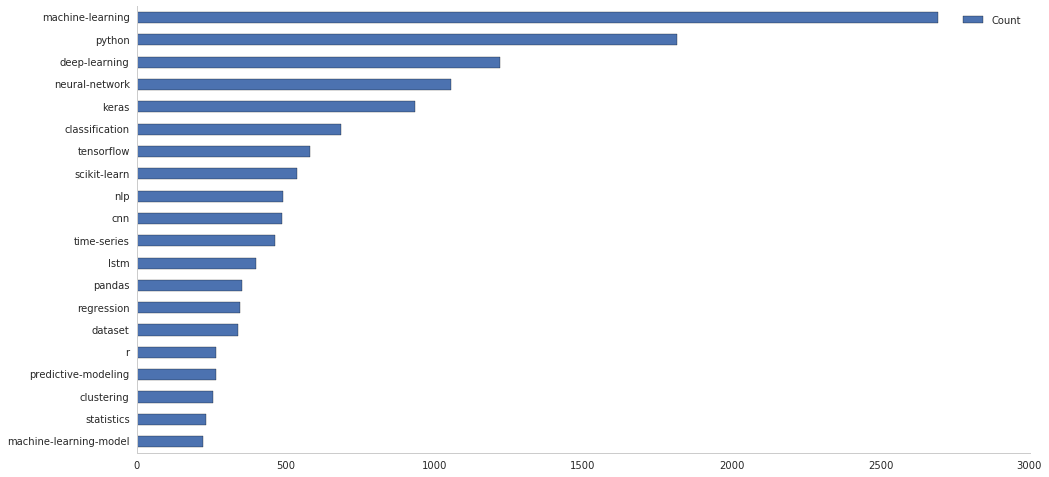

In [13]:
most_used.plot.barh(figsize=(16,8))
sns.despine()

Some tags are very, very broad and are unlikely to be useful; e.g.: python, dataset, r. Before we investigate the tags a little deeper, let's repeat the same process for views.

We'll use pandas's pandas.DataFrame.iterrows()

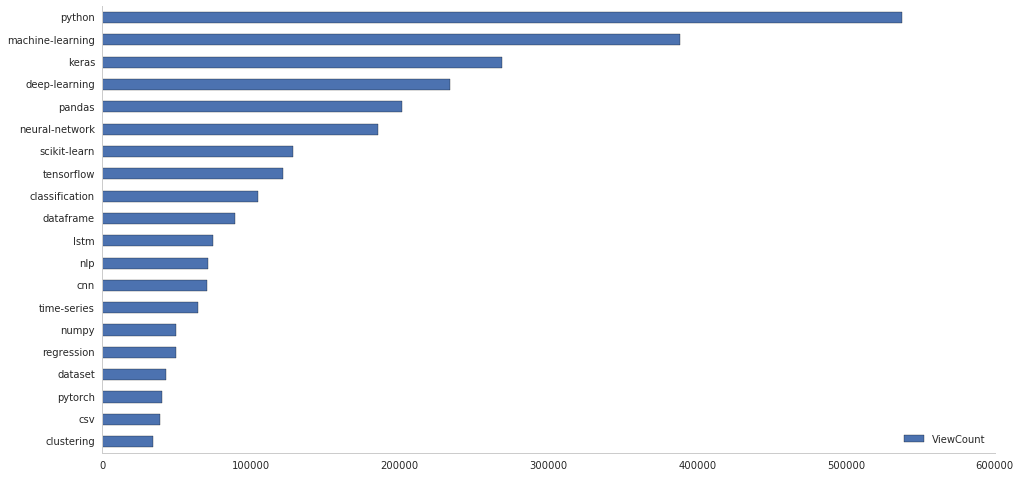

In [14]:
tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']

            
# For improved aesthetics, let's transform tag_count in a dataframe           
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)


# Let's now sort this dataframe by Count and visualize the top 20 results 
most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)


# Visualize the data
most_viewed.plot(kind="barh", figsize=(16,8))
sns.despine()

Lets see the tag_count and tag_view_count bar plots side by side

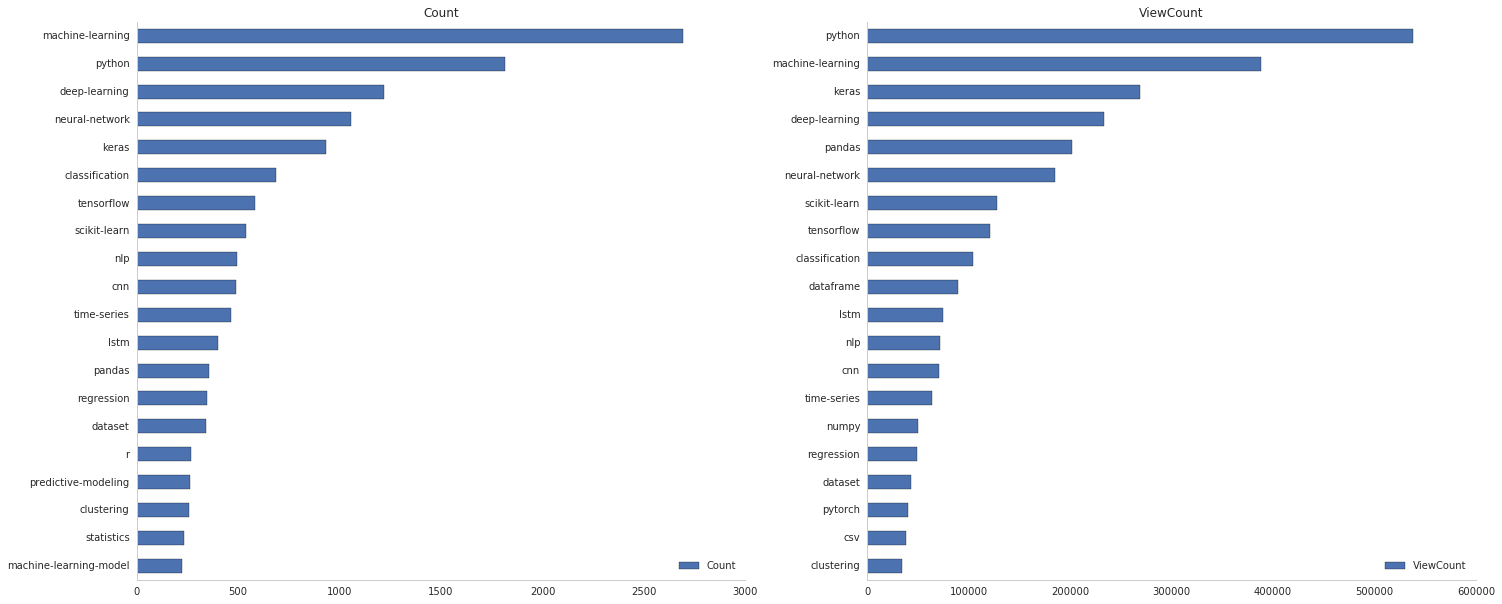

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))

most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

sns.despine()

Looking at the results from the above plots, we see that most top tags are present in both dataframes.

But there are tags that are in most_used, but not in most_viewed and vice versa.



In [16]:
# joining the most used and most viewed dfs to see the tag differences btw the two

in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

The tags present in most_used and not present in most_viewed are:

   * machine-learning-model
   * statistics
   * predictive-modeling
   * r

And the tags present in most_viewed but not in most_used are:

   * csv
   * pytorch
   * dataframe


## Enter Domain Knowledge

Domain knowledge can be very useful. We can see that the most used tags are also the most viewed. From the top 10 tags of each, here's a list of the tags in common: `python, machine-learning, deep-learning, neural-network, keras, tensorflow, classification, scikit-learn.`


We need to know what each of these or most of these tags means? Could there be strong relations between them? We can do additional research on the internet as needed.


Keras, scikit-learn, TensorFlow are all Python libraries that allow their users to employ deep learning (a type of neural network).

Most of the top tags are all intimately related with one central machine learning theme: deep learning. If we want to be very specific, we can suggest the creation of Python content that uses deep learning for classification problems (and other variations of this suggestion).

At the glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.


## Just a Fad?

Before we officially make our recommendation, it would be nice to solidy our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? 

To answer the above question, we have to run the following query against the SEDE DSSE database, then download the dataset in csv format:

`SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;`
 
This query fetches all of the questions ever asked on DSSE, their dates and tags. The csv file is called all_questions.csv. We will track the interest in deep learning across time. We will:

   * Count how many deep learning questions are asked per time period.
   * The total amount of questions per time period.
   * How many deep learning questions there are relative to the total amount of questions per time period

Let's read in the file into a dataframe called all_q. We'll parse the dates at read-time.


In [17]:
all_q = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

In [19]:
#Transforming the Tags column like we previously did in the other dataset

all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")



Before deciding which questions should be classified as being deep learning questions, we should decide what tags are deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list `["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].`

This list was obtained by looking at all the tags in most_used and seeing which ones had any relation to deep learning. 

We'll now create a function that assigns 1 to deep learning questions and 0 otherwise; and we use it.


In [20]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

In [21]:
all_q["DeepLearning"] = all_q["Tags"].apply(class_deep_learning)

In [22]:
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning
18553,64447,2019-12-09 05:15:05,"[machine-learning, scikit-learn, cross-validat...",1
16031,23462,2017-10-02 09:48:13,[machine-learning],0
3984,16491,2017-01-24 11:38:07,"[machine-learning, python, classification, svm]",0
5114,47648,2019-03-20 04:17:04,"[keras, predictive-modeling]",1
17403,24120,2017-10-27 06:12:27,"[machine-learning, deep-learning, random-fores...",1




Looks good!

The data-science-techonology landscape isn't something as dynamic to merit daily, weekly, or even monthly tracking. Let's track it quarterly.

Since we don't have all the data for the first quarter of 2020, we'll get rid of those dates:


In [23]:
all_q = all_q[all_q["CreationDate"].dt.year < 2020]

Let's create a column that identifies the quarter in which a question was asked.

In [37]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(fetch_quarter)

In [38]:
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning,Quarter
15903,11232,2016-04-15 14:16:12,"[bigdata, predictive-modeling]",0,16Q2
11527,61427,2019-10-08 11:48:00,"[machine-learning, dataset, cnn, svm, cross-va...",1,19Q4
12573,51882,2019-05-13 12:20:16,"[neural-network, classification, accuracy]",1,19Q2
3993,16519,2017-01-25 09:04:55,"[python, nlp, nltk, mongodb]",0,17Q1
10407,42139,2018-12-05 03:09:24,"[deep-learning, nlp, word2vec, word-embeddings...",1,18Q4




For the final stretch, we'll group by quarter and:

   * Count the number of deep learning questions.
   * Count the total number of questions.
   * Compute the ratio between the two numbers above.



In [39]:
quarterly = all_q.groupby('Quarter').agg({'DeepLearning':['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']


# Remember that a groupby object is a dataframe, so we can add a column to it
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]


# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)    

quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
15,18Q1,554,1221,0.453726
20,19Q2,935,2393,0.390723
10,16Q4,177,527,0.335863
7,16Q1,110,516,0.213178
1,14Q3,13,189,0.068783


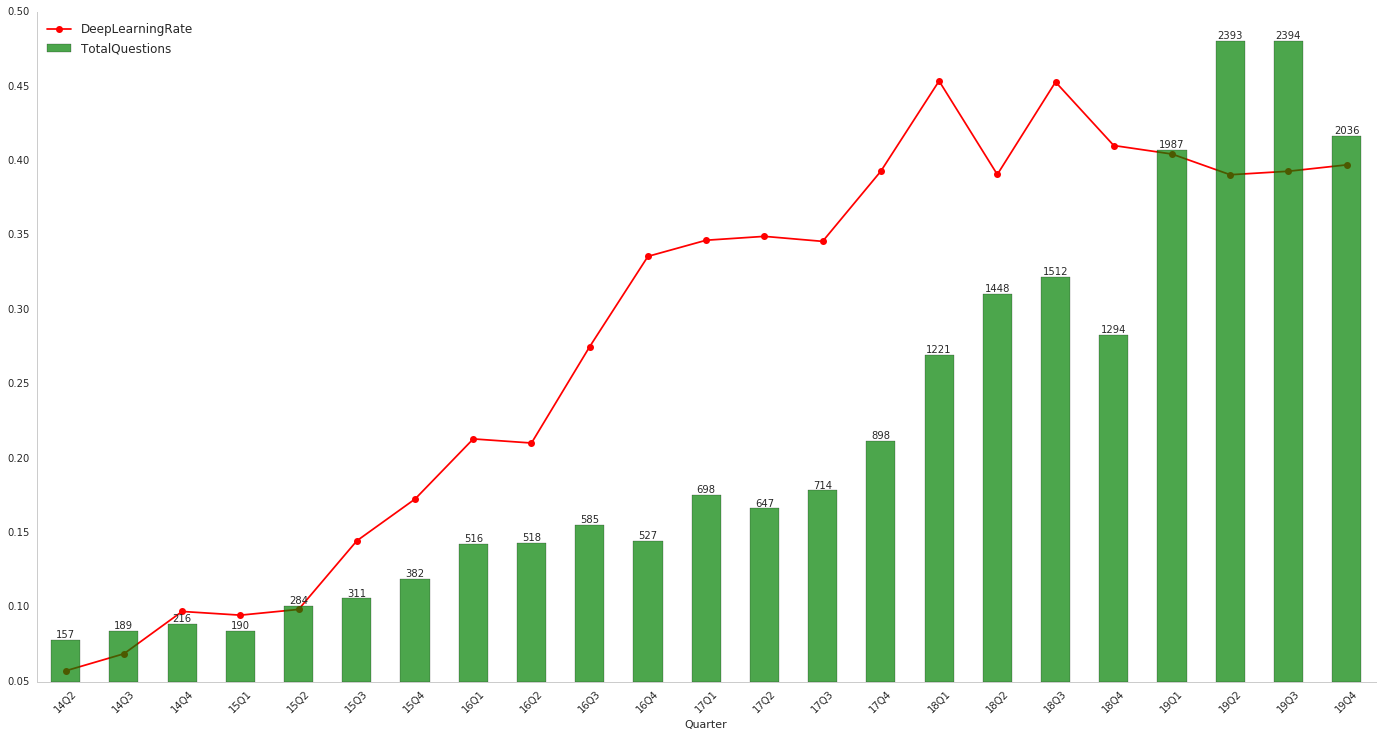

In [71]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="red",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", color='green', 
                     ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
    
xlims = ax1.get_xlim()
ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

# Conclusion
It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.